In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import csv
import skimage
import skimage.transform

images = np.load("./images.npy")
labels = np.load("./labels.npy")
test = np.load("./part_2_test_images.npy")
height = images.shape[1]
width = images.shape[2]
size = height * width
pre_images = images
images = (images - images.mean()) / images.std()
data = images.reshape(images.shape[0],size)
data = torch.from_numpy(data).float().cuda()
labels = torch.from_numpy(labels).float().cuda()
test_data = test.reshape(test.shape[0], size)
test_data = (test_data - test_data.mean()) / test_data.std()
test_data = torch.from_numpy(test_data).float().cuda()
batch_size = 1
NUM_OPT_STEPS = 5000
train_seqs = data[0:45000,:]
train_labels = labels[0:45000]
val_seqs = data[45000:,:]
val_labels = labels[45000:]
NUM_CLASSES = 5

In [11]:
class TooSimpleConvNN(torch.nn.Module):
    def __init__(self, chan_1, chan_2, chan_3, chan_4):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, chan_1, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(chan_1, chan_2, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(chan_2, chan_3, kernel_size=3, stride=1)
        self.conv4 = torch.nn.Conv2d(chan_3, chan_4, kernel_size=3, stride=1)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(chan_4, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, height, width).unsqueeze(1)

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=1)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=1)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=3, stride=1)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x


In [12]:
def train(model, optimizer, batch_size):
#def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_seqs.shape[0], size=batch_size, replace=False)
    i = torch.from_numpy(i).long().cuda()
    x = autograd.Variable(train_seqs[i, :])
    y = autograd.Variable(train_labels[i]).long()
    i.cpu()
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [13]:
def approx_train_accuracy(model):
    i = np.random.choice(train_seqs.shape[0], size=1000, replace=False)
    i = torch.from_numpy(i).long().cuda()
    x = autograd.Variable(train_seqs[i, :])
    y = autograd.Variable(train_labels[i]).long()
    y_hat_ = model(x)
    y_hat = np.zeros(1000)
    for i in range(1000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.cpu().numpy())

In [14]:
def val_accuracy(model):
    x = autograd.Variable(val_seqs)
    y = autograd.Variable(val_labels)
    y_hat_ = model(x)
    y_hat = np.zeros(5000)
    for i in range(5000):
        y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
    return accuracy(y_hat, y.data.cpu().numpy())

In [15]:
def accuracy(y, y_hat):
    return (y == y_hat).astype(np.float).mean()

In [16]:
def plot(train_accs, val_accs):
    plt.figure(200)
    plt.title('Training Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.plot(train_accs, 'b')
    plt.show()
    plt.figure(300)
    plt.title('Validation Accuracy')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')   
    plt.plot(val_accs, 'b')
    plt.show()

In [17]:
def runModel(model, batch_size, NUM_OPT_STEPS, optimizer):
    train_accs, val_accs = [], []
    for i in range(NUM_OPT_STEPS):
        train(model, optimizer, batch_size)
        if i % 100 == 0:
            train_accs.append(approx_train_accuracy(model))
            val_accs.append(val_accuracy(model))
            print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))
    plot(train_accs, val_accs)

     0  0.20  0.20
   100  0.69  0.68
   200  0.76  0.75
   300  0.77  0.79
   400  0.84  0.81
   500  0.82  0.82
   600  0.83  0.83
   700  0.84  0.83
   800  0.84  0.84
   900  0.84  0.84
  1000  0.84  0.84
  1100  0.84  0.85
  1200  0.85  0.85
  1300  0.86  0.86
  1400  0.84  0.85
  1500  0.86  0.86
  1600  0.87  0.86
  1700  0.88  0.86
  1800  0.86  0.87
  1900  0.88  0.87
  2000  0.87  0.88
  2100  0.88  0.88
  2200  0.87  0.87
  2300  0.89  0.88
  2400  0.87  0.88
  2500  0.85  0.86
  2600  0.87  0.88
  2700  0.90  0.88
  2800  0.89  0.89
  2900  0.89  0.89
  3000  0.88  0.89
  3100  0.88  0.88
  3200  0.89  0.89
  3300  0.88  0.89
  3400  0.87  0.88
  3500  0.88  0.89
  3600  0.90  0.89
  3700  0.91  0.90
  3800  0.90  0.89
  3900  0.91  0.89
  4000  0.91  0.90
  4100  0.89  0.89
  4200  0.89  0.89
  4300  0.88  0.89
  4400  0.92  0.90
  4500  0.88  0.89
  4600  0.90  0.88
  4700  0.91  0.89
  4800  0.91  0.90
  4900  0.92  0.90


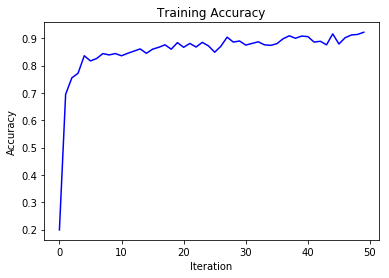

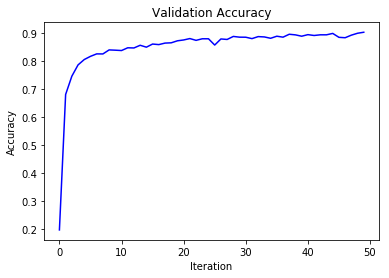

In [110]:
layer_1 = 8 #average
layer_2 = 16
layer_3 = 24
layer_4 = 32
batch = 64
rate = 0.001
step = 5000
model = TooSimpleConvNN(layer_1, layer_2, layer_3, layer_4)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=rate)
runModel(model, batch, step, optimizer)

     0  0.19  0.20
   100  0.79  0.77
   200  0.84  0.81
   300  0.84  0.83
   400  0.82  0.83
   500  0.86  0.86
   600  0.84  0.85
   700  0.88  0.86
   800  0.89  0.88
   900  0.87  0.88
  1000  0.88  0.88
  1100  0.88  0.89
  1200  0.90  0.89
  1300  0.91  0.89
  1400  0.88  0.87
  1500  0.91  0.90
  1600  0.91  0.90
  1700  0.90  0.90
  1800  0.91  0.90
  1900  0.89  0.90
  2000  0.91  0.91
  2100  0.91  0.91
  2200  0.93  0.91
  2300  0.91  0.91
  2400  0.90  0.91
  2500  0.89  0.90
  2600  0.91  0.91
  2700  0.94  0.92
  2800  0.91  0.91
  2900  0.93  0.92
  3000  0.94  0.92
  3100  0.90  0.91
  3200  0.94  0.93
  3300  0.90  0.90
  3400  0.94  0.92
  3500  0.94  0.92
  3600  0.91  0.92
  3700  0.92  0.91
  3800  0.93  0.93
  3900  0.93  0.92
  4000  0.94  0.92
  4100  0.91  0.91
  4200  0.94  0.93
  4300  0.94  0.93
  4400  0.92  0.92
  4500  0.92  0.92
  4600  0.93  0.93
  4700  0.94  0.93
  4800  0.93  0.92
  4900  0.95  0.93
  5000  0.94  0.92
  5100  0.94  0.93
  5200  0.94

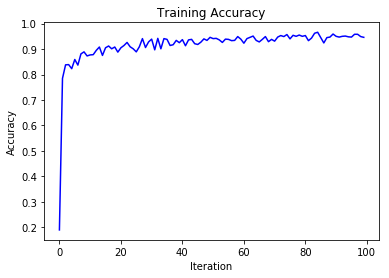

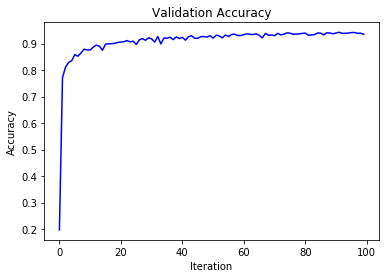

In [9]:
layer_1 = 16 #better
layer_2 = 32
layer_3 = 64
layer_4 = 128
batch = 50
rate = 0.001
step = 10000
model = TooSimpleConvNN(layer_1, layer_2, layer_3, layer_4)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=rate)
runModel(model, batch, step, optimizer)

     0  0.20  0.20
   100  0.76  0.79
   200  0.80  0.80
   300  0.81  0.81
   400  0.82  0.82
   500  0.85  0.83
   600  0.82  0.85
   700  0.82  0.80
   800  0.86  0.85
   900  0.87  0.87
  1000  0.86  0.87
  1100  0.88  0.87
  1200  0.88  0.87
  1300  0.88  0.87
  1400  0.86  0.86
  1500  0.88  0.87
  1600  0.87  0.86
  1700  0.88  0.88
  1800  0.86  0.88
  1900  0.89  0.89
  2000  0.88  0.88
  2100  0.88  0.88
  2200  0.91  0.89
  2300  0.91  0.89
  2400  0.89  0.89
  2500  0.89  0.89
  2600  0.90  0.91
  2700  0.89  0.89
  2800  0.91  0.90
  2900  0.89  0.90
  3000  0.90  0.90
  3100  0.91  0.90
  3200  0.91  0.91
  3300  0.92  0.92
  3400  0.91  0.91
  3500  0.90  0.90
  3600  0.93  0.92
  3700  0.90  0.88
  3800  0.92  0.91
  3900  0.90  0.91
  4000  0.92  0.91
  4100  0.92  0.92
  4200  0.93  0.92
  4300  0.92  0.92
  4400  0.92  0.92
  4500  0.93  0.92
  4600  0.91  0.91
  4700  0.93  0.92
  4800  0.92  0.92
  4900  0.91  0.92
  5000  0.94  0.92
  5100  0.92  0.92
  5200  0.94

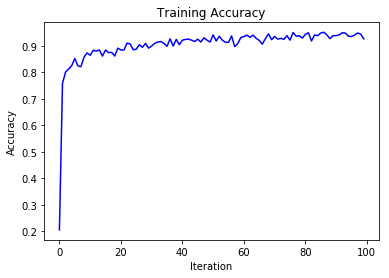

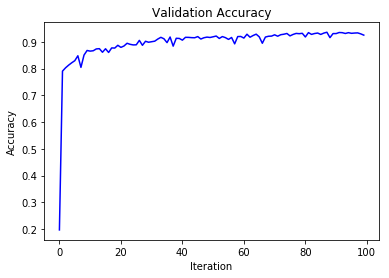

In [9]:
layer_1 = 16 #better
layer_2 = 32
layer_3 = 64
layer_4 = 128
batch = 32
rate = 0.001
step = 10000
model = TooSimpleConvNN(layer_1, layer_2, layer_3, layer_4)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=rate)
runModel(model, batch, step, optimizer)

My starting point was with the basic two layer neural network.
I tried optimizing the hyper parameters for it and found that my accuracy was capped around 86.

I started trying more convolutional layers to get better accuracy and was able to raise it to 94-95 accuracy using 4 convolutional layers. 

The optimizer I used was the Adam optimizer at a learning rate of 0.001 with a mini batch size of 64. I tried varying the batch size but when I chose something over 100 my training became incredibly slow. My training was also particularly slow when I increased the number of channels at every convolution layer. To circumvent this problem i decided to train on my GPU which allowed for faster training.
 
Along with that, intially I had a bit of overfitting with my model and to decrease my overfitting I decided to max pool after every convolution layer to help with down sampling.

The most important changes to achieving high accuracy I made were increasing the number of layers, and getting a pyramid like structure with my channels. 

What my model does is that it has 4 convolution layers which each output an image with different number of channels. The number of channels I usually set it up with are in a "pyramid" shape, IE 32 64 128 256. When my model makes its prediction it will first take in image data with one channel and then take a 3x3 convolution and then output an image with chan_1 number of channels. I then send that output into my relu activation function and run a max pool in order to get data that is closer bounded and get some down sampling to reduce some overfitting. I then run through the rest of the layers in the same fashion with the only difference being that each layer outputs an image with a different number of channels. I still feed my output of every layer into my relu activation function and run a max pool each time. At the very end I run a 1x1 convolution and output an image with 5 channels that correspond to the class scores. I then take the argmax of those scores and use that as my prediction.

In [20]:
with open('jzhan127_part2.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'label'])
    
    x = autograd.Variable(test_data)
    y_hat_ = model(x)
    for i in range(5000):
        filewriter.writerow([i, torch.max(y_hat_[i,:].data, 0)[1][0]])

Kaggle Submission: jzhan127_part2.csv

EXPLORING FAILURE MODES

In [18]:
with open('test.csv', 'w', newline='') as csvfile:
    filewriter = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
    filewriter.writerow(['id', 'label'])
    
    x = autograd.Variable(val_seqs)
    y_hat_ = model(x)
    for i in range(45000, 50000):
        filewriter.writerow([i-45000, torch.max(y_hat_[i - 45000,:].data, 0)[1][0], val_labels[i - 45000]])

RIGHT IMAGES


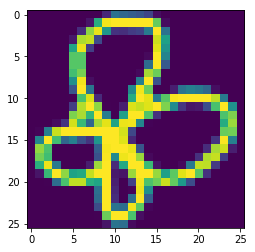

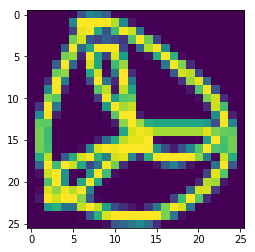

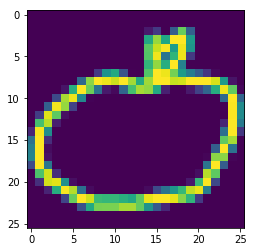

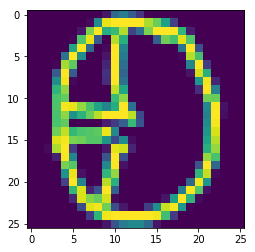

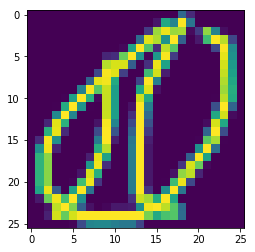

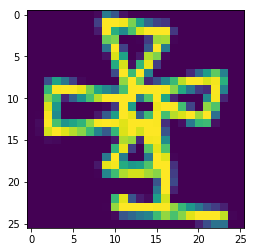

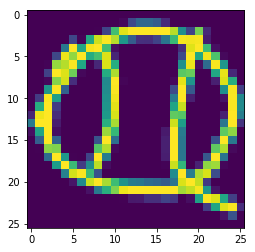

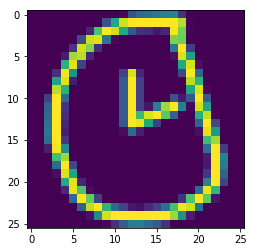

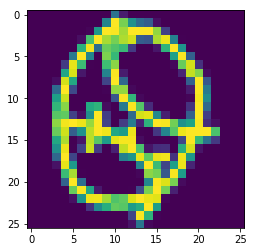

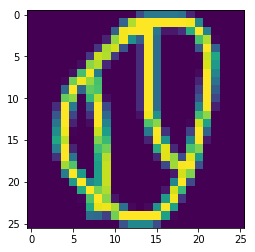

In [79]:
wrong = [images[45000], images[45002], images[45004], images[45012], images[45013], images[45017], images[45024], images[45038], images[45041], images[45075]]
right = [images[45001], images[45003], images[45005], images[45006], images[45007], images[45008], images[45010], images[45014], images[45015], images[45029]]
print("RIGHT IMAGES")
for i in range(10):
    plt.figure(i)
    plt.imshow(right[i])

WRONG IMAGES


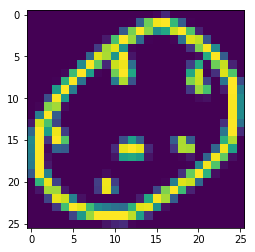

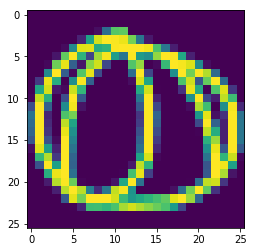

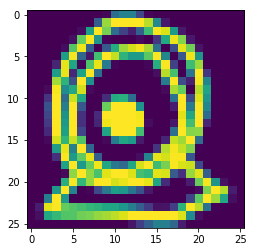

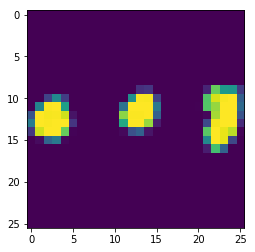

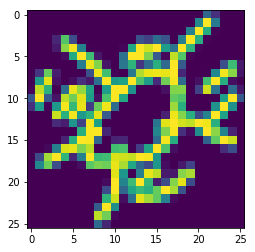

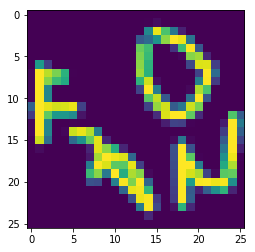

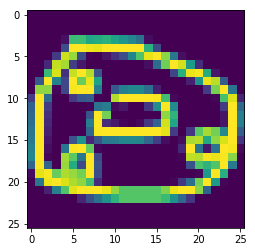

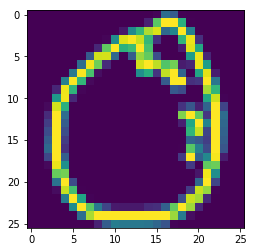

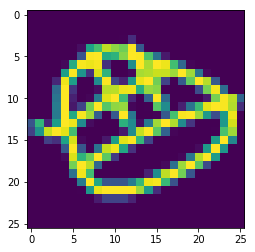

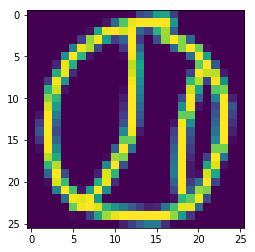

In [78]:
print("WRONG IMAGES")
for j in range(10):
    plt.figure(j+10)
    plt.imshow(wrong[j])

The image quality of both sets are about the same. However in the wrong set the images seem to have slightly different features that make it more difficult to classify. The misclassified examples are slightly more difficult to classify as a human because it is hard to make out what the image is. They're fairly unclear and messy which make it hard to discern what the image is supposed to be.

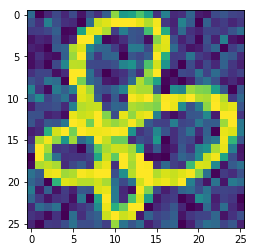

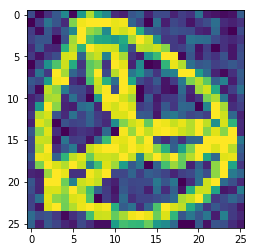

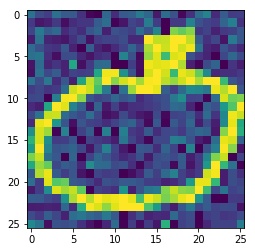

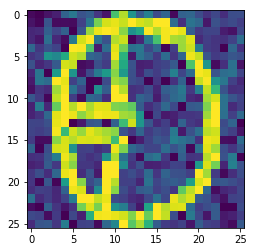

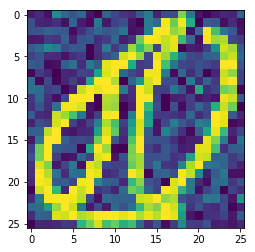

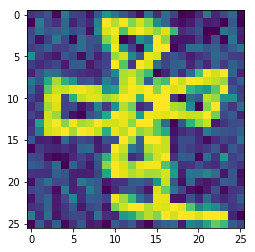

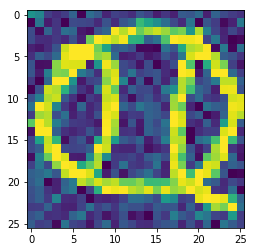

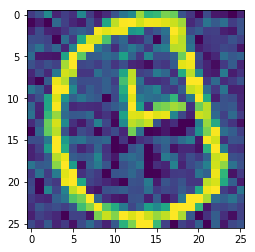

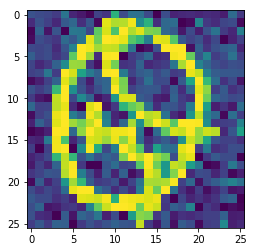

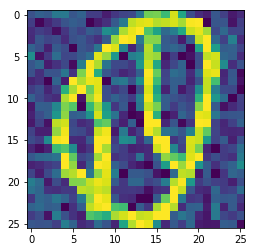

In [88]:
noise_add = right
for i in range(10):
    noise_add[i]= skimage.util.random_noise(noise_add[i], mode='gaussian', seed=None, clip=True)
    plt.figure(i)
    plt.imshow(noise_add[i])

In [97]:
right_lab = [labels[45001], labels[45003], labels[45005], labels[45006], labels[45007], labels[45008], labels[45010], labels[45014], labels[45015], labels[45029]]
right_lab = np.array(right_lab)
x = autograd.Variable(torch.from_numpy(np.array(noise_add)).cuda().float())
y_hat_ = model(x)
y_hat = np.zeros(10)
for i in range(10):
    y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
print(accuracy(y_hat, right_lab))

0.1


It does not classify the 10 images correctly. In fact it led to an even worse accuracy. 

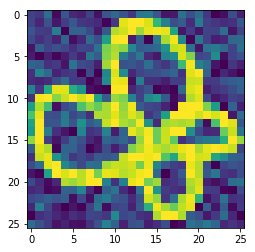

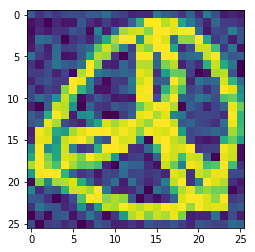

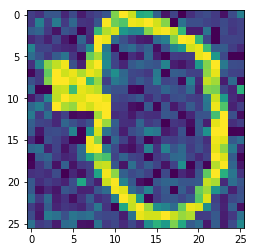

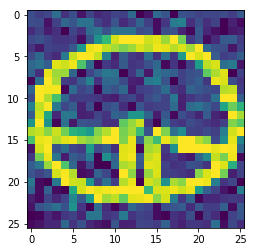

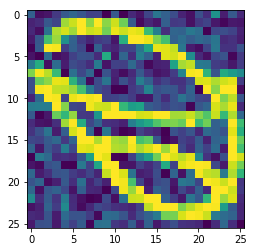

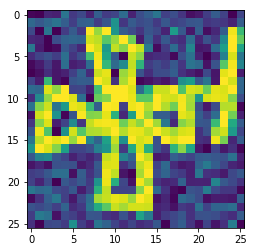

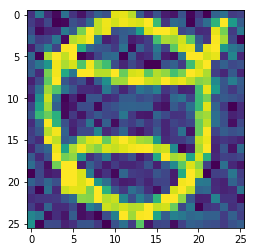

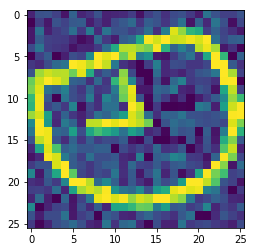

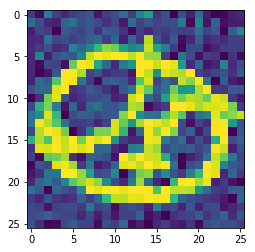

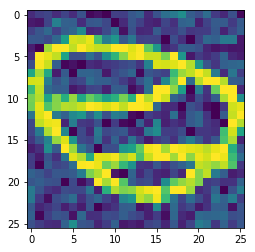

In [106]:
to_flip = right
for i in range(10):
    to_flip[i] = skimage.transform.rotate(to_flip[i], 90)
    plt.figure(i)
    plt.imshow(to_flip[i])

In [113]:
right_lab = [labels[45001], labels[45003], labels[45005], labels[45006], labels[45007], labels[45008], labels[45010], labels[45014], labels[45015], labels[45029]]
right_lab = np.array(right_lab)
x = autograd.Variable(torch.from_numpy(np.array(to_flip)).cuda().float())
y_hat_ = model(x)
y_hat = np.zeros(10)
for i in range(10):
    y_hat[i] = torch.max(y_hat_[i,:].data, 0)[1][0]
print(accuracy(y_hat, right_lab))

0.0


My classifier was not able to classify these 10 images correctly.

Yes there are scenarios when we want to remain invariant to horizontal flipping because there are certain objects that may be sensitive to orientation which would allow us to classify them as those objects. To remain invariant to horizontal flipping we could randomly flip images when we are training and our model will have to train with these flips which will allow our model to be sensitive to flipping and allow our model to remain robust to such transformations.

Kaggle submission: jzhan127_part2.csv